**<div style="text-align: right;">30th October, 2024</div>**

**FINM 35000 - Topics in Economics**
<br>
Autumn 2024

<h2><center> Data Project 1 </center></h2>

### Team Members:
- Antonio Pineda Acosta
- Kaleem Shah Bukhari
- Muhammad Raafay Uqaily
- Yasmine Ouattara

### Import Statements

In [154]:
import re
import nltk
import torch
import string
import requests
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf
from io import StringIO
from fredapi import Fred
from scipy.stats import iqr
import statsmodels.api as sm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from transformers import pipeline
import matplotlib.dates as mdates
import xml.etree.ElementTree as ET
from sklearn.linear_model import LinearRegression
from nltk.tokenize import sent_tokenize, word_tokenize

import warnings
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.6f}'.format

### Section 2: Measuring the tone of FOMC statements

#### 1. (10 points) Scrape the text of the FOMC statements from January 2000 to the present. 

Use https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm for 2019-2024 and https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm for 2000-2018.

Here are some hints provided by Joanna for scraping if scraping is new to you.

- Use the BeautifulSoup package to extract the html from the website. Load this package by running the code: from bs4 import BeautifulSoup.

- Use the command soup.findall(‘a’,href=True) to get a list of all the URL links on the web page.

- Inspect the URLs to figure out what the format of the links to statement files look like and narrow your list of links to only include these.

- Iterate through the links to the statements and again use the BeautifulSoup package to extract the text.

- Inspect the text to remove extraneous parts from the start and end. Make sure to remove HTML tags.

- You will need the date of the statement to merge the text to the returns. It can be found in the URL. For example, https: //www.federalreserve.gov/newsevents/pressreleases/monetary20220126a.htm  was released on Jan. 26, 2022, which is at the end of the URL.

Report the following after you extract the text: 1) Number of statements you obtain and the list of the dates of their release. The statements are released shortly after each FOMC meeting. 2) A summary statistic of the number of words in statements including mean, standard deviation, minimum, first quartile, median, third quartile, maximum.

### 2019-2024

These functions aim to scrape and extract press release statements from the Federal Open Market Committee (FOMC) for the years 2019-2024. The script accomplishes this by visiting a webpage containing links to FOMC statements, extracting the links for each statement, scraping the textual content of each statement, and saving the cleaned and relevant statement text along with its publication date into an Excel file.

In [102]:
# Function to extract the statement links from the 2019-2024 URL
def extract_statement_links_2019_2024(url):
    """
    Extracts the URLs containing FOMC press release statements from a given webpage.

    Input:
        url (str): The URL of the webpage to scrape.

    Output:
        list of str: A list of URLs containing FOMC press release statements.
    """
    # Send a GET request to the specified URL
    response = requests.get(url)
    # Parse the HTML content of the webpage using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all anchor tags with 'href' attribute
    fomc_links = soup.find_all('a', href=True)
    
    # Filter the links for URLs containing 'pressrelease' in their paths (assuming FOMC statements use this pattern)
    statement_links = [link['href'] for link in fomc_links if 'pressrelease' in link['href']]
    
    return statement_links

# Function to clean and extract the relevant FOMC statement text
def extract_statement_text_2019_2024(links):
    """
    Extracts and cleans relevant FOMC statement text from the provided list of URLs.

    Input:
        links (list): A list of URLs containing FOMC statements.

    Output:
        statements (list), dates (list): A list of relevant statements & a list of release dates.
    """
    base_url = "https://www.federalreserve.gov"
    statements = []
    dates = []
    
    # Loop through each link to extract statement text and publication date
    for link in links:
        # Construct the full URL by appending the base URL
        full_url = base_url + link
        statement_response = requests.get(full_url)
        
        # Decode the response content as UTF-8 to handle encoding issues
        statement_soup = BeautifulSoup(statement_response.content.decode('utf-8'), 'html.parser')
        
        # Extract the entire text content from the webpage
        full_text = statement_soup.get_text().strip()

        # Define markers to identify the start and end of the relevant statement text
        start_marker = "Please enable JavaScript if it is disabled in your browser or access the information through the links provided below."
        end_marker = "About the FedNews & EventsMonetary PolicySupervision & RegulationFinancial StabilityPayment SystemsEconomic ResearchDataConsumers & CommunitiesConnect with the Board"
        
        # Find the indices of the start and end markers
        start_index = full_text.find(start_marker)
        end_index = full_text.find(end_marker)
        
        # If both markers are found, extract the text between them
        if start_index != -1 and end_index != -1:
            relevant_text = full_text[start_index + len(start_marker):end_index]
            
            # Extract the date from the URL using a regular expression (assuming a pattern like 20220126a.htm)
            match = re.search(r'(\d{8})a\.htm', link)
            
            if relevant_text and match:  # Ensure both statement text and date are found
                date = match.group(1)  # Extract the date part (e.g., 20220126)
                dates.append(date)
                statements.append(relevant_text.strip())
    
    return statements, dates

# URL for scraping 2019-2024 statements
url_2019_2024 = "https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm"

# Extract statement links for the 2019-2024 period
statement_links_2019_2024 = extract_statement_links_2019_2024(url_2019_2024)

# Extract statement texts and dates for the 2019-2024 period
statements_2019_2024, dates_2019_2024 = extract_statement_text_2019_2024(statement_links_2019_2024)

# Create a dataframe for the 2019-2024 period
data_2019_2024 = {'Date': dates_2019_2024, 'Statement Text': statements_2019_2024}
df_2019_2024 = pd.DataFrame(data_2019_2024)

# Convert the date format to 'YYYY-MM-DD'
df_2019_2024['Date'] = pd.to_datetime(df_2019_2024['Date'], format='%Y%m%d')
df_2019_2024['Date'] = df_2019_2024['Date'].dt.strftime('%Y-%m-%d')

# Save the DataFrame to an Excel file
output_file_path_2019_2024 = 'Data/FOMC_statements_2019_2024.xlsx'
df_2019_2024.to_excel(output_file_path_2019_2024, index=False)

df_2019_2024

,Date,Statement Text
0,2024-01-31,"January 31, 2024\nFederal Reserve issues FOMC ..."
1,2024-03-20,"March 20, 2024\nFederal Reserve issues FOMC st..."
2,2024-05-01,"May 01, 2024\nFederal Reserve issues FOMC stat..."
3,2024-06-12,"June 12, 2024\nFederal Reserve issues FOMC sta..."
4,2024-07-31,"July 31, 2024\nFederal Reserve issues FOMC sta..."
5,2024-09-18,"September 18, 2024\nFederal Reserve issues FOM..."
6,2023-02-01,"February 01, 2023\nFederal Reserve issues FOMC..."
7,2023-03-22,"March 22, 2023\nFederal Reserve issues FOMC st..."
8,2023-05-03,"May 03, 2023\nFederal Reserve issues FOMC stat..."
9,2023-06-14,"June 14, 2023\nFederal Reserve issues FOMC sta..."


### 2000-2018

The code extracts FOMC Beige Book statements from the Federal Reserve website for the years 2000 to 2018. It dynamically constructs the URLs based on the year, extracts the relevant links to Beige Book reports, and then fetches and processes the text from each link. The extracted statement texts are filtered and saved in a structured format along with the associated publication dates. The final output is saved into an Excel file.

In [103]:
# List of specific dates to remove
dates_to_remove = [
    "1996-10-01", "1996-12-01", "1997-01-01", "1997-03-01", "1997-05-01", "1997-06-01",
    "1997-08-01", "1997-09-01", "1997-10-01", "1997-12-01", "1998-01-01", "1998-03-01",
    "1998-05-01", "1998-06-01", "1998-08-01", "1998-09-01", "1998-11-01", "1998-12-01",
    "1999-01-01", "1999-03-01", "1999-05-01", "1999-06-01", "1999-08-01", "1999-09-01",
    "1999-11-01", "1999-12-01", "2000-01-01", "2000-03-01", "2000-05-01", "2000-06-01",
    "2000-08-01", "2000-09-01", "2000-11-01", "2000-12-01", "2001-01-01", "2001-03-01",
    "2001-05-01", "2001-06-01", "2001-08-01", "2001-09-01", "2001-10-01", "2001-11-01",
    "2002-01-01", "2002-03-01", "2002-04-01", "2002-06-01", "2002-07-01", "2002-10-01",
    "2002-11-01", "2003-01-01", "2003-03-01", "2003-04-01", "2003-06-01", "2003-07-01",
    "2003-10-01", "2003-11-01", "2004-01-01", "2004-03-01", "2004-04-01", "2004-06-01",
    "2004-07-01", "2004-09-01", "2004-10-01", "2004-12-01", "2005-01-01", "2005-03-01",
    "2005-04-01", "2005-06-01", "2005-07-01", "2005-09-01", "2005-10-01", "2005-11-01",
    "2006-01-01", "2006-03-01", "2006-04-01", "2006-06-01", "2006-07-01", "2006-09-01",
    "2006-10-01", "2006-11-01", "2007-01-01", "2007-03-01", "2007-04-01", "2007-06-01",
    "2007-07-01", "2007-09-01", "2007-10-01", "2007-11-01", "2008-01-01", "2008-03-01",
    "2008-04-01", "2008-06-01", "2008-07-01", "2008-09-01", "2008-10-01", "2008-12-01",
    "2009-01-01", "2009-03-01", "2009-04-01", "2009-06-01", "2009-07-01", "2009-09-01",
    "2009-10-01", "2009-12-01", "2010-01-01", "2010-03-01", "2010-04-01", "2010-06-01",
    "2010-07-01", "2010-09-01", "2010-10-01", "2010-12-01"
]

In [104]:
# Function to extract the statement links for a given year based on its period
def extract_yearly_links(year):
    """
    Extracts the Beige Book statement links for a given year based on its period.

    Input:
        year (int): The year for which to extract statement links.

    Output:
        list of str: A list of URLs containing links to the Beige Book statements.
    """
    # Determine the URL and link pattern based on the year
    if 2000 <= year <= 2010:
        url = f"https://www.federalreserve.gov/monetarypolicy/fomchistorical{year}.htm"
        link_pattern = r'/fomc/beigebook/\d{4}/\d{8}/default.htm'
    elif 2011 <= year <= 2016:
        url = f"https://www.federalreserve.gov/monetarypolicy/beigebook/beigebook{year}.htm"
        link_pattern = r'/monetarypolicy/beigebook/beigebook\d{6}.htm'
    else:  # 2017-2018
        url = f"https://www.federalreserve.gov/monetarypolicy/beigebook{year}.htm"
        link_pattern = r'/monetarypolicy/beigebook\d{6}.htm'

    # Send a GET request to fetch the page content
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    links = soup.find_all('a', href=True)
    
    # Filter only the relevant Beige Book links based on the defined pattern
    relevant_links = [link['href'] for link in links if re.search(link_pattern, link['href'])]
    
    return relevant_links

# Function to extract the statement text from an HTML link
def extract_statement_text(link):
    """
    Extracts the relevant Beige Book statement text from a given link.

    Input:
        link (str): The URL or path to the Beige Book statement page.

    Output:
        str: The extracted relevant text, or None if no relevant text found.
    """
    base_url = "https://www.federalreserve.gov"
    full_url = base_url + link if link.startswith('/') else base_url + '/' + link
    response = requests.get(full_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    text = soup.get_text().strip()
    
    # Phrase that marks the start of relevant content
    start_marker = "the views of Federal Reserve officials."
    # Find the starting point in the text
    start_index = text.find(start_marker)
    
    if start_index != -1:
        # Extract the relevant part after the start_marker
        relevant_text = text[start_index + len(start_marker):].strip()
        return relevant_text
    else:
        # If the start marker is not found, return None
        return None

# Function to extract FOMC statements for a given year range
def extract_fomc_statements(start_year, end_year):
    """
    Extracts Beige Book statements for a range of years and filters them based on the defined criteria.

    Input:
        start_year (int): The starting year of the range.
        end_year (int): The ending year of the range.

    Output:
        DataFrame: A DataFrame containing statement dates and texts, sorted chronologically.
    """
    all_statements = []
    all_dates = []

    # Loop through each year in the specified range
    for year in range(start_year, end_year + 1):
        links = extract_yearly_links(year)

        # Loop through each link to extract the statement text and date
        for link in links:
            # Match and extract the date from the URL based on the year range
            if year <= 2010:
                match = re.search(r'/fomc/beigebook/(\d{4})/(\d{8})/default.htm', link)
            else:
                match = re.search(r'beigebook(\d{4})(\d{2})', link)

            if match:
                # Extract the date based on the matched pattern
                if year <= 2010:
                    date = match.group(2)
                else:
                    year_str = match.group(1)
                    month = match.group(2)
                    date = f"{year_str}{month}01"

                if date not in all_dates:  # Prevent duplicate entries
                    statement_text = extract_statement_text(link)
                    if statement_text:  # Only append if the relevant text is found
                        all_dates.append(date)
                        all_statements.append(statement_text)

    # Convert the date strings to datetime objects for filtering and sorting
    all_dates = pd.to_datetime(all_dates, format='%Y%m%d')
    
    # Create a DataFrame with the filtered and ordered data
    df = pd.DataFrame({'Date': all_dates, 'Statement Text': all_statements})

    # Filter out the specific dates we want to remove
    df = df[~df['Date'].isin(pd.to_datetime(dates_to_remove))]

    df = df.sort_values(by='Date')  # Sort by date

    return df

# Extract statements for each period and combine them
df_2000_2010 = extract_fomc_statements(2000, 2010)
df_2011_2016 = extract_fomc_statements(2011, 2016)
df_2017_2018 = extract_fomc_statements(2017, 2018)

# Merge all the DataFrames into one
df_2000_2018 = pd.concat([df_2000_2010, df_2011_2016, df_2017_2018])

# Save the final DataFrame to a single Excel file
output_file_path = 'Data/FOMC_statements_2000_2018_filtered_cleaned.xlsx'
df_2000_2018.to_excel(output_file_path, index=False)

df_2000_2018

,Date,Statement Text
0,2000-01-19,Reports from most Federal Reserve Districts in...
1,2000-03-08,Reports from the twelve Federal Reserve Distri...
2,2000-05-03,Reports from the twelve Federal Reserve Distri...
3,2000-06-14,Reports from the Federal Reserve Districts ind...
4,2000-08-09,The information collected for these reports su...
...,...,...
11,2018-05-01,Overall Economic Activity\r\nEconomic activity...
12,2018-07-01,Overall Economic Activity\r\nEconomic activity...
13,2018-09-01,Federal Reserve Bank of Boston\nFederal Reserv...
14,2018-10-01,Federal Reserve Bank of Boston\nFederal Reserv...


In [105]:
# Merge all the DataFrames into one
df_all_years = pd.concat([df_2000_2018, df_2019_2024])

# Ensure 'Date' column is in datetime format
df_all_years['Date'] = pd.to_datetime(df_all_years['Date']).dt.strftime('%Y-%m-%d')

# Order by date
df_all_years = df_all_years.sort_values(by='Date')

df_all_years.tail()

,Date,Statement Text
1,2024-03-20,"March 20, 2024\nFederal Reserve issues FOMC st..."
2,2024-05-01,"May 01, 2024\nFederal Reserve issues FOMC stat..."
3,2024-06-12,"June 12, 2024\nFederal Reserve issues FOMC sta..."
4,2024-07-31,"July 31, 2024\nFederal Reserve issues FOMC sta..."
5,2024-09-18,"September 18, 2024\nFederal Reserve issues FOM..."


In [106]:
def report_extracted_statements(df):
    """
    Reports the number of statements extracted and lists the dates of their release.

    Input:
        df (DataFrame): DataFrame containing the FOMC statements and their release dates.

    Output:
        statement_count (int): Number of statements extracted.
        date_list (list of str): List of release dates in 'YYYY-MM-DD' format.
    """
    # Count the number of statements
    statement_count = len(df)

    # Extract the list of dates and convert them to strings
    date_list = df['Date'].tolist()

    # Print the results
    print(f"Number of Statements Extracted: {statement_count}")
    print("List of Dates of Release:")
    for date in date_list:
        print(date)

    return statement_count, date_list

statement_count, date_list = report_extracted_statements(df_all_years)

Number of Statements Extracted: 170
List of Dates of Release:
2000-01-19
2000-03-08
2000-05-03
2000-06-14
2000-08-09
2000-09-20
2000-12-06
2001-01-17
2001-03-07
2001-05-02
2001-06-13
2001-08-08
2001-09-19
2001-10-24
2001-11-28
2002-01-16
2002-06-12
2002-07-31
2002-10-23
2002-11-27
2003-01-15
2004-01-14
2004-03-03
2004-04-21
2004-06-16
2004-07-28
2004-09-08
2004-10-27
2007-01-17
2007-03-07
2007-04-25
2007-06-13
2007-07-25
2007-09-05
2007-10-17
2007-11-28
2008-01-16
2008-03-05
2008-04-16
2008-07-23
2008-09-03
2008-10-15
2008-12-03
2009-01-14
2009-03-04
2009-04-15
2009-06-10
2009-07-29
2009-09-09
2009-10-21
2009-12-02
2010-03-03
2010-04-14
2010-06-09
2010-07-28
2010-09-08
2010-10-20
2011-01-01
2011-04-01
2011-06-01
2011-07-01
2011-09-01
2011-10-01
2011-11-01
2012-01-01
2012-02-01
2012-04-01
2012-06-01
2012-07-01
2012-08-01
2012-10-01
2012-11-01
2013-01-01
2013-03-01
2013-04-01
2013-06-01
2013-07-01
2013-09-01
2013-10-01
2013-12-01
2014-01-01
2014-03-01
2014-04-01
2014-06-01
2014-07-01
201

In [107]:
# Add the word count for each statement
df_all_years['Word Count'] = df_all_years['Statement Text'].apply(lambda x: len(x.split()))

# Calculate summary statistics for the word count
summary_stats = df_all_years['Word Count'].describe()

# Display the summary statistics
summary_stats

count     170.000000
mean     7124.458824
std      7892.273684
min       163.000000
25%       526.500000
50%      2032.000000
75%     17232.500000
max     20050.000000
Name: Word Count, dtype: float64

In [9]:
# Save the final DataFrame and summary statistics to a single Excel file
output_file_path = 'Output_Files/FOMC_statements_with_summary_statistics.xlsx'

# Save both the data and the summary statistics in the same Excel file using ExcelWriter
with pd.ExcelWriter(output_file_path) as writer:
    df_all_years.to_excel(writer, sheet_name='FOMC Statements', index=False)
    summary_stats.to_frame(name='Summary Statistics').to_excel(writer, sheet_name='Summary Statistics')

#### 2. (30 points) Follow Tadle (2022) section 3.1 (pages 4-8) to measure the tone of each FOMC statement. Here is a brief description of his method and some programming suggestions.

- Split the statement into sentences using sent tokenize from the nltk package in Python.

- Remove punctuation and capitalization.

- Remove all sentences that do not contain any keywords defined as those from the hawkish or dovish lists in the Excel file provided (Tadle 2022 keywords).

- For each remaining sentence, count the number of positive and negative keywords, adjusting for negation terms. For example, “When a positive term is in the proximity (occurred after three words or less) of a negation term, then its effect is counted as negative.” See Table 3 in Tadle (2022) for a list of examples.

- Use equation (1) on page 7 of Tadle (2022) to assign sentiment scores to each sentence. Footnote 13 on page 7 tells you how to handle sentences that contain both hawkish and dovish keywords.

- Aggregate across sentences to get the document-level score for each FOMC statement by following equation (2) on page 7 of Tadle (2022).

Plot the computed sentiment of each FOMC statement since January 2000. Please plot the dots only; donot connect dots with lines.

In [108]:
# Loading the keywords into a DataFrame
keywords_df = pd.read_excel('Data/Tadle_2022_keywords.xlsx')

# Display the first 5 rows of the dataframe
keywords_df.head()

,hawkish,dovish,positive,negative,negation
0,business,accomodation,abating,adverse,fail
1,economy,downturn,augmented,contracting,less
2,equity,unemployment,booming,damping,never
3,housing,devastation,elevating,declining,no
4,inflationary,recession,extended,depressed,not


In [12]:
# Converting DataFrame into a Dictionary
# Keys: Word Categories ('hawkish', 'dovish', 'positive', 'negative', 'negation')
# Values: List of words associated with each word category

list_of_categories = ['hawkish', 'dovish', 'positive', 'negative', 'negation']

# Empty Dictionary to store word categories and associated values
keywords_dict = {}

# Loop over the dataframe to populate the dictionary
for cat_ in list_of_categories:
    cat_words_list = keywords_df[cat_].dropna().tolist()
    if cat_ not in keywords_dict:
        keywords_dict[cat_] = cat_words_list

The code below defines a function to process and clean FOMC statements, focusing on identifying sentences that contain key financial terms labeled as "hawkish" or "dovish." The function achieves this by splitting the statement text into sentences, removing punctuation and normalizing capitalization, and checking each sentence for the presence of keywords. It then organizes the cleaned and categorized sentences into separate dictionaries based on the date of each statement.

In [109]:
# Function to clean and process sentences from FOMC statements
def clean_process_sentences(statements_df, hawkish_word_list, dovish_word_list):
    """
    Cleans and processes FOMC statements to extract relevant sentences based on keyword presence.

    Input:
        statements_df (DataFrame): A DataFrame containing FOMC statements and their dates.
        hawkish_word_list (list): List of hawkish keywords.
        dovish_word_list (list): List of dovish keywords.

    Output:
        tokenized_sentence_dict (dictionary): A dictionary where the key is the statement date, and the value is a list of tokenized sentences.
        hawkish_dovish_sentence_dict (dictionary): A dictionary where the key is the statement date, and the value is a list of relevant sentences containing hawkish or dovish keywords.
    """

    # Make a copy of the input DataFrame to avoid altering the original data
    statements_df = statements_df.copy()
    
    # Combine hawkish and dovish keyword lists into one list for easier checking
    keyword_list_combined = hawkish_word_list.copy() + dovish_word_list.copy()
    
    # Initialize empty dictionaries to store the results
    tokenized_sentence_dict = {}       # Holds all tokenized sentences for each statement date
    clean_sentences_dict = {}          # Holds all cleaned sentences for each statement date
    hawkish_dovish_sentence_dict = {}  # Holds sentences containing at least one hawkish or dovish keyword
    irrelevant_sentences_dict = {}     # Holds sentences without any hawkish or dovish keywords

    # Loop through each statement in the DataFrame
    for index, stmnt in statements_df.iterrows():
        
        # Tokenize the statement text into individual sentences
        statement = str(stmnt['Statement Text'])
        tokenized_sentences = sent_tokenize(statement)
        
        # Add the tokenized sentences to the dictionary, using the statement's date as the key
        if stmnt['Date'] not in tokenized_sentence_dict:
            tokenized_sentence_dict[stmnt['Date']] = tokenized_sentences
        
        # Initialize empty lists to store cleaned and categorized sentences
        clean_sentences_list = []
        hawkish_dovish_sentence_list = []
        irrelevant_sentences_list = []
        
        # Loop through each tokenized sentence
        for sntnc in tokenized_sentences:
        
            # Tokenize the sentence into words and clean by removing punctuation and converting to lowercase
            tokenized_words = word_tokenize(sntnc)
            clean_tokenized_words = [word_.lower() for word_ in tokenized_words if word_ not in string.punctuation]
            clean_sentence = ' '.join(clean_tokenized_words)
            clean_sentences_list.append(clean_sentence)
            
            # Check if the cleaned sentence contains any of the hawkish or dovish keywords
            if any(word_ in keyword_list_combined for word_ in clean_tokenized_words):
                hawkish_dovish_sentence_list.append(clean_sentence)
            else:
                irrelevant_sentences_list.append(clean_sentence)
        
        # Add the cleaned sentences to the dictionary, using the statement's date as the key
        if stmnt['Date'] not in clean_sentences_dict:
            clean_sentences_dict[stmnt['Date']] = clean_sentences_list
        
        # Add the hawkish/dovish sentences to the dictionary, using the statement's date as the key
        if stmnt['Date'] not in hawkish_dovish_sentence_dict:
            hawkish_dovish_sentence_dict[stmnt['Date']] = hawkish_dovish_sentence_list
        
        # Add irrelevant sentences to the dictionary, using the statement's date as the key
        if stmnt['Date'] not in irrelevant_sentences_dict:
            irrelevant_sentences_dict[stmnt['Date']] = irrelevant_sentences_list
        
    return tokenized_sentence_dict, hawkish_dovish_sentence_dict, irrelevant_sentences_dict

The function calculate_sentence_score analyzes a list of words (representing a sentence) to determine its sentiment and categorization based on the presence of hawkish, dovish, positive, negative, and negation-related keywords. It counts the occurrences of these words in the sentence and considers the proximity of negation words to adjust sentiment accordingly. The function returns a sentiment score based on these counts, indicating whether the sentence expresses a positive, negative, or neutral sentiment in the context of hawkish or dovish terms.

In [110]:
def calculate_sentence_score(list_of_words, hawkish_word_list, dovish_word_list, 
                             positive_word_list, negative_word_list, negation_word_list):
    """
    Calculates a sentiment score for a given list of words based on hawkish, dovish, positive, negative, and negation keywords.

    Input:
        list_of_words (list): The list of words (tokens) representing a sentence.
        hawkish_word_list (list): List of hawkish keywords.
        dovish_word_list (list): List of dovish keywords.
        positive_word_list (list): List of positive sentiment keywords.
        negative_word_list (list): List of negative sentiment keywords.
        negation_word_list (list): List of negation words (e.g., 'not', 'never').

    Output:
        int: A score indicating the sentiment:
            - 1 for positive hawkish or negative dovish sentiment.
            - -1 for negative hawkish or positive dovish sentiment.
            - 0 for neutral or absence of hawkish/dovish sentiment.
    """
    # Initialize counters for different word categories
    hawkish_word_cnt = 0
    dovish_word_cnt = 0
    positive_word_cnt = 0
    negative_word_cnt = 0
    negation_proximity_threshold = 3  # Number of words to check for proximity to negation

    # Loop through each word in the given list of words
    for idx, word_ in enumerate(list_of_words):
        # Count occurrences of hawkish and dovish words
        if word_ in hawkish_word_list:
            hawkish_word_cnt += 1
        
        if word_ in dovish_word_list:
            dovish_word_cnt += 1
        
        # Check for positive words and consider negation proximity
        if word_ in positive_word_list:
            # Check if there is a negation word within the proximity threshold
            left_limit = max(0, idx - negation_proximity_threshold)
            if any(negation_word in list_of_words[left_limit:idx] for negation_word in negation_word_list):
                negative_word_cnt += 1  # Negation found, so treat as negative sentiment
            else:
                positive_word_cnt += 1  # No negation, count as positive sentiment
        
        # Check for negative words and consider negation proximity
        elif word_ in negative_word_list:
            left_limit = max(0, idx - 1)
            if any(negation_word in list_of_words[left_limit:idx] for negation_word in negation_word_list):
                positive_word_cnt += 1  # Negation found, so treat as positive sentiment
            else:
                negative_word_cnt += 1  # No negation, count as negative sentiment

    # Determine the final sentiment score based on the counts of hawkish, dovish, positive, and negative words
    if hawkish_word_cnt > 0:
        if positive_word_cnt == negative_word_cnt:
            return 1  # Only hawkish words without sentiment differentiation
        elif positive_word_cnt > negative_word_cnt:
            return 1  # Positive hawkish sentiment
        else:
            return -1  # Negative hawkish sentiment

    elif dovish_word_cnt > 0:
        if positive_word_cnt == negative_word_cnt:
            return -1  # Only dovish words without sentiment differentiation
        elif positive_word_cnt > negative_word_cnt:
            return -1  # Negative dovish sentiment
        else:
            return 1  # Positive dovish sentiment

    else:
        return 0  # Neutral sentiment if no hawkish or dovish words found

The function assign_sentence_score takes a dictionary of relevant sentences categorized by dates and evaluates each sentence using the calculate_sentence_score function. This function returns a score of 1, -1, or 0 based on the presence of hawkish, dovish, positive, negative, and negation keywords in the sentence. The scores are stored in a nested dictionary where each date corresponds to another dictionary containing sentences and their respective scores.

In [111]:
# Function to assign scores to each sentence based on sentiment analysis
def assign_sentence_score(relevant_sentence_dict, hawkish_word_list, dovish_word_list,
                          positive_word_list, negative_word_list, negation_word_list):
    """
    Assigns a sentiment score to each sentence based on the presence of hawkish, dovish, positive, negative, and negation keywords.

    Input:
        relevant_sentence_dict (dict): A dictionary where the key is the date, and the value is a list of relevant sentences.
        hawkish_word_list (list): List of hawkish keywords.
        dovish_word_list (list): List of dovish keywords.
        positive_word_list (list): List of positive sentiment keywords.
        negative_word_list (list): List of negative sentiment keywords.
        negation_word_list (list): List of negation words (e.g., 'not', 'never').

    Output:
        date_sentence_score_dict (dict): A dictionary where:
                                          - key: date of the statement
                                          - value: a nested dictionary with key as sentence and value as the score of that sentence
    """
    # Initialize an empty dictionary to store sentence scores for each date
    date_sentence_score_dict = {}
    
    # Loop through each date and list of sentences in the relevant_sentence_dict
    for date, list_of_sentences in relevant_sentence_dict.items():
        
        # Initialize a dictionary to store sentence scores for the current date
        sentence_score_dict = {}

        # Loop through each sentence in the list of sentences
        for sntnc in list_of_sentences:
            
            # Tokenize the sentence into individual words
            tokenized_words_list = word_tokenize(sntnc)
            
            # Calculate the score for the sentence using the calculate_sentence_score function
            sentence_score = calculate_sentence_score(tokenized_words_list, hawkish_word_list, dovish_word_list, 
                                                      positive_word_list, negative_word_list, negation_word_list)
            
            # Assign the calculated score to the sentence in the dictionary
            sentence_score_dict[sntnc] = sentence_score
        
        # Assign the sentence scores for the current date in the final dictionary
        date_sentence_score_dict[date] = sentence_score_dict
    
    # Return the final dictionary containing sentence scores for each date
    return date_sentence_score_dict

The function assign_document_score evaluates an overall sentiment score for each document (FOMC statement) by aggregating the sentiment scores of individual sentences within each document. It calls the assign_sentence_score function to obtain sentence-level scores and then calculates a document-level score based on the sum of all sentence scores. The final document score is normalized as an index to reflect the relative sentiment intensity of the entire document.

In [112]:
# Function to assign a document-level sentiment score based on sentence-level scores
def assign_document_score(relevant_sentence_dict, hawkish_word_list, dovish_word_list,
                          positive_word_list, negative_word_list, negation_word_list):
    """
    Assigns an overall sentiment score to each document by aggregating the scores of its sentences.

    Input:
        relevant_sentence_dict (dict): A dictionary where the key is the date, and the value is a list of relevant sentences.
        hawkish_word_list (list): List of hawkish keywords.
        dovish_word_list (list): List of dovish keywords.
        positive_word_list (list): List of positive sentiment keywords.
        negative_word_list (list): List of negative sentiment keywords.
        negation_word_list (list): List of negation words (e.g., 'not', 'never').

    Output:
        date_document_score_index_dict (dict): A dictionary where:
                                               - key: date of the statement
                                               - value: a sentiment index score for the entire document
    """
    # Get the sentence-level scores using the assign_sentence_score function
    date_sentence_score_dict = assign_sentence_score(relevant_sentence_dict, hawkish_word_list, dovish_word_list, 
                                                     positive_word_list, negative_word_list, negation_word_list)
    
    # Initialize a dictionary to store document scores for each date
    date_document_score_index_dict = {}

    # Loop through each date and its corresponding sentence scores
    for date, sentence_score_dict in date_sentence_score_dict.items():
        
        # Calculate the total score and the number of relevant sentences in the document
        total_document_score = sum(sentence_score_dict.values())
        num_rlvnt_sntncs = len(sentence_score_dict.keys())
        
        # Calculate a sentiment index for the document using a normalized formula
        index_ = 100 * (1 / num_rlvnt_sntncs) * total_document_score if num_rlvnt_sntncs > 0 else 0
        date_document_score_index_dict[date] = index_
    
    # Return the final dictionary containing the document-level sentiment scores
    return date_document_score_index_dict

In [114]:
keywords_hawkish = keywords_dict['hawkish']
keywords_dovish = keywords_dict['dovish']
keywords_positive = keywords_dict['positive']
keywords_negative = keywords_dict['negative']
keywords_negation = keywords_dict['negation']

In [115]:
sntnc_dict, hwksh_dvsh_sntnc_dict, irlvnt_sntc_dict = clean_process_sentences(df_all_years, keywords_hawkish, keywords_dovish)

In [116]:
date_indx_score_dict = assign_document_score(hwksh_dvsh_sntnc_dict,keywords_hawkish, keywords_dovish, keywords_positive, keywords_negative, keywords_negation)

In [117]:
date_indx_score_df = pd.DataFrame.from_dict(date_indx_score_dict, orient = 'index')
date_indx_score_df.reset_index(inplace = True)
date_indx_score_df.rename(columns = {'index':'Date', 0:'Index Score'}, inplace = True)
date_indx_score_df.head()

,Date,Index Score
0,2000-01-19,75.000000
1,2000-03-08,86.046512
2,2000-05-03,89.189189
3,2000-06-14,56.000000
4,2000-08-09,44.680851


In [118]:
# Save the DataFrame for Index (Sentiment) Scores against each Press Release Date into an excel sheet
output_file_path = 'Output_Files/FOMC_statement_date_sentiment_score.xlsx'

with pd.ExcelWriter(output_file_path) as writer:
    date_indx_score_df.to_excel(writer, sheet_name = 'Sentiment Score', index=False)

In [119]:
date_indx_score_df = pd.read_excel('Output_Files/FOMC_statement_date_sentiment_score.xlsx')

In [120]:
date_indx_score_df['Date'] = pd.to_datetime(date_indx_score_df['Date'])
date_indx_score_df.set_index('Date', inplace=True)

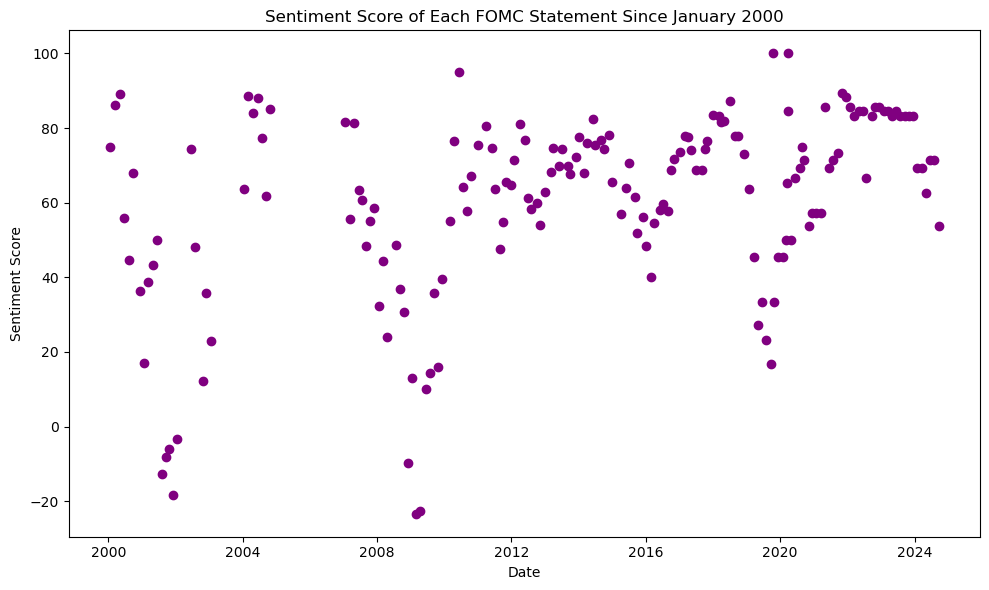

In [121]:
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot with dot size based on "Index Score"
ax.scatter(date_indx_score_df.index, date_indx_score_df["Index Score"],color = 'purple')

# Set title and labels
ax.set_title("Sentiment Score of Each FOMC Statement Since January 2000")
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment Score")

# Adjust layout and display
plt.tight_layout()
plt.show()

We look at the distribution of the Sentiment Score to decide the thresholds for Dovish, Hawkish, and Neutral scores.

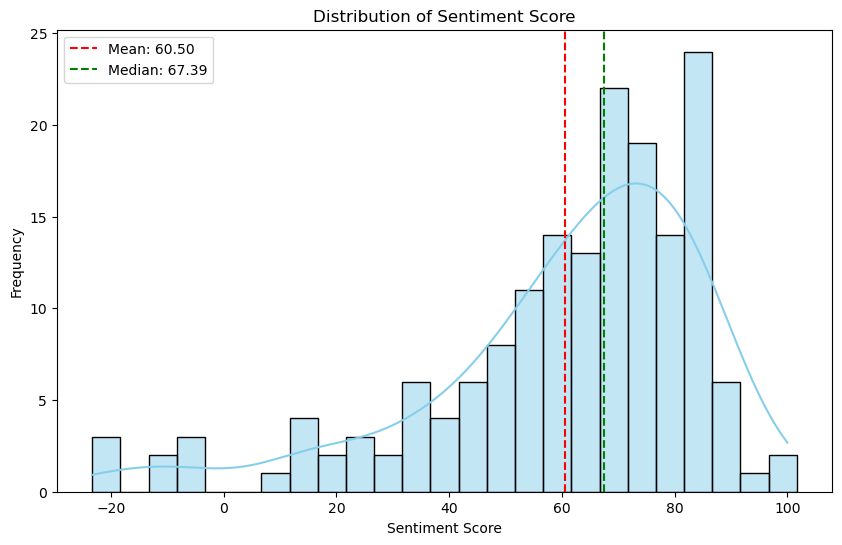

In [122]:
# Calculate the mean and median of the 'Index Score' column
mean_score = date_indx_score_df['Index Score'].mean()
median_score = date_indx_score_df['Index Score'].median()

# Create a histogram plot to show the distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(date_indx_score_df['Index Score'], kde=True, binwidth=5, color='skyblue', edgecolor='black')

# Plot vertical lines to indicate the mean and median sentiment scores
plt.axvline(mean_score, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_score:.2f}')
plt.axvline(median_score, color='green', linestyle='--', linewidth=1.5, label=f'Median: {median_score:.2f}')

# Add plot title and labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()

We see that the distribution is right skewed, with mean < median value. Therefore, we have used quantiles to define thresholds for dovish, neutral, and hawkish scores. As given in the table below.

In [123]:
# Define thresholds for categorizing sentiment scores based on percentiles
dovish_threshold = date_indx_score_df['Index Score'].quantile(0.25)  # 25th percentile
neutral_threshold = date_indx_score_df['Index Score'].quantile(0.50)  # 50th percentile (median)
hawkish_threshold = date_indx_score_df['Index Score'].quantile(0.75)  # 75th percentile

# Create a DataFrame to display the ranges for each sentiment category
ranges_df = pd.DataFrame({'Category': ['Dovish', 'Neutral', 'Hawkish'],
                          'Range': [f"Score < {dovish_threshold:.2f}",
                                    f"{neutral_threshold:.2f} <= Score <= {hawkish_threshold:.2f}",
                                    f"Score > {hawkish_threshold:.2f}"]})

# Display the ranges DataFrame
ranges_df

,Category,Range
0,Dovish,Score < 50.00
1,Neutral,67.39 <= Score <= 77.54
2,Hawkish,Score > 77.54


#### 3. (10 points) From FRED (Federal Reserve Economic Data, https://fred.stlouisfed.org/) find the following data series: 
- 1) Federal Funds Target Rate (DFEDTAR) and 
- 2) Federal Funds Target Range-Upper (DFEDTARU). 

You can search the “ticker symbol” (Capital letters in parenthesis) for each series given. FOMC used to announce a targeted value for the Federal Funds Rate (FFR) before Dec. 15th, 2008. 

Since that date, FOMC has announced a range. We will use the upper limit. Compute the change of the target on each of the FOMC statement release date. Plot these changes together with sentiment score you computed in the previous section. What do you find?

In [27]:
fred_api_key = '6014571ef89b16f87265e5d0b7644011' 
fred = Fred(api_key = fred_api_key)
api_key = fred_api_key

The function fetch_multiple_fred_data retrieves multiple economic time series from the Federal Reserve Economic Data (FRED) API in a single operation. It takes a list of series IDs, requests data for each series, processes the XML response, and organizes the results into a pandas DataFrame. 

In [124]:
def fetch_multiple_fred_data(series_ids):
    """
    Fetch multiple time series from FRED in one go.

    Parameters:
    - series_ids: list of str, each representing a FRED series ID.

    Returns:
    - DataFrame with each series as a column, indexed by date.
    """
    # Initialize an empty dictionary to store data for each series
    data = {}

    # Loop through each series ID to fetch data from FRED
    for series_id in series_ids:
        # Construct the API request URL for the current series ID
        url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=xml"
        response = requests.get(url)  # Send an HTTP GET request to fetch data
        response_text = response.text  # Extract the response text (XML format)
        
        # Parse the XML response text to extract data
        root = ET.fromstring(response_text)
        series_data = {}
        
        # Loop through each 'observation' node in the XML response
        for observation in root.findall(".//observation"):
            date = observation.get('date')  # Extract the date attribute
            value = observation.get('value')  # Extract the value attribute
            try:
                # Convert the value to a float, if possible
                series_data[date] = float(value)
            except ValueError:
                # If the value is non-numeric, set it to None
                series_data[date] = None
        
        # Store the series data as a pandas Series in the main data dictionary
        data[series_id] = pd.Series(series_data)

    # Combine all series into a single DataFrame, indexed by date
    result_df = pd.DataFrame(data)
    result_df.index.name = 'Date'  # Set the index name as 'Date'
    result_df = result_df.reset_index()  # Reset index to make 'Date' a column

    # Return the final DataFrame containing all series
    return result_df

The function fetch_fred_data retrieves and processes time series data for a specific series ID from the Federal Reserve Economic Data (FRED) API. It sends an API request to fetch data in XML format, parses the XML to extract dates and values, and handles any non-numeric values gracefully. The extracted data is returned as a pandas Series indexed by date, which allows for easy integration with other time series analysis workflows.

In [125]:
def fetch_fred_data(series_id):
    """
    Fetches a specific time series from FRED and returns it as a pandas Series.

    Parameters:
    - series_id: str, representing the FRED series ID to fetch.

    Returns:
    - pd.Series containing the fetched data, indexed by date.
    """
    # Construct the API request URL for the given series ID
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=xml"
    
    # Send an HTTP GET request to the FRED API and retrieve the response text in XML format
    response = requests.get(url)
    response_text = response.text
    
    # Parse the XML response text to extract data
    root = ET.fromstring(response_text)
    data = {}
    
    # Loop through each 'observation' node in the XML response
    for observation in root.findall(".//observation"):
        # Extract the date and value attributes from each observation
        date = observation.get('date')
        value = observation.get('value')
        
        # Attempt to convert the value to a float, handling non-numeric values gracefully
        try:
            data[date] = float(value)
        except ValueError:
            data[date] = None  # Assign None to non-numeric or missing values
    
    # Return the extracted data as a pandas Series, indexed by date
    return pd.Series(data)

In [126]:
# Fetch data for each series
dfedtar_data = fetch_fred_data('DFEDTAR')
dfedtaru_data = fetch_fred_data('DFEDTARU')

# Combine into a DataFrame
fed_data = pd.DataFrame({'DFEDTAR': dfedtar_data, 'DFEDTARU': dfedtaru_data})

# Convert the index to datetime format
fed_data.index = pd.to_datetime(fed_data.index)

# Define cutoff date and create Target_Rate column
cutoff_date = pd.Timestamp('2008-12-15')
fed_data['Target_Rate'] = fed_data.apply(
    lambda row: row['DFEDTAR'] if row.name <= cutoff_date else row['DFEDTARU'], axis=1
)

# Drop unnecessary columns and display the result
fed_data = fed_data.drop(columns=['DFEDTAR', 'DFEDTARU']).reset_index().rename(columns={'index':'Date'})
fed_data.head()

,Date,Target_Rate
0,1982-09-27,10.250000
1,1982-09-28,10.250000
2,1982-09-29,10.250000
3,1982-09-30,10.250000
4,1982-10-01,10.000000


In [128]:
# Reset the index for the date index score DataFrame
date_indx_score_df.reset_index(inplace=True)
date_indx_score_df['Date'] = pd.to_datetime(date_indx_score_df['Date'])  # Convert 'Date' column to datetime

# Merge the sentiment score DataFrame with the target rate DataFrame on 'Date'
doc_index_score_ffr_target_df = pd.merge(date_indx_score_df, fed_data, left_on='Date', right_on='Date', how='inner')

# Calculate the difference in the target rate to measure the change in monetary policy (MPOL)
doc_index_score_ffr_target_df['MPOL'] = doc_index_score_ffr_target_df['Target_Rate'].diff()

doc_index_score_ffr_target_df.head()

,index,Date,Index Score,Target_Rate,MPOL
0,0,2000-01-19,75.000000,5.500000,NaN
1,1,2000-03-08,86.046512,5.750000,0.250000
2,2,2000-05-03,89.189189,6.000000,0.250000
3,3,2000-06-14,56.000000,6.500000,0.500000
4,4,2000-08-09,44.680851,6.500000,0.000000


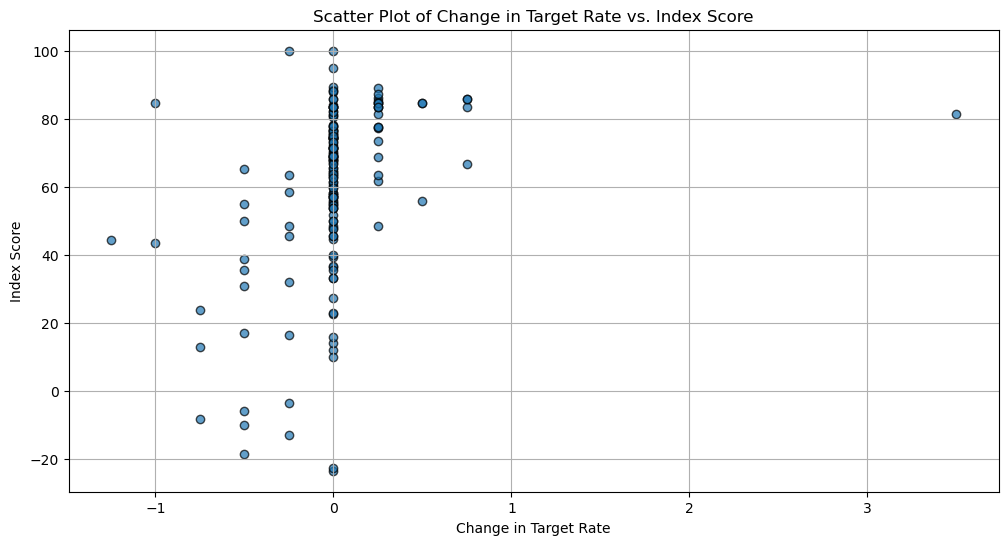

In [129]:
# Plotting the relationship between change in target rate (MPOL) and the sentiment index score
plt.figure(figsize=(12, 6))

# Create a scatter plot of MPOL (change in target rate) against the Index Score
plt.scatter(doc_index_score_ffr_target_df['MPOL'], doc_index_score_ffr_target_df['Index Score'], 
            alpha=0.7, edgecolor='k')

# Set plot labels and title
plt.xlabel('Change in Target Rate')
plt.ylabel('Index Score')
plt.title('Scatter Plot of Change in Target Rate vs. Index Score')

# Add a grid for better readability
plt.grid()

# Display the plot
plt.show()

We can observe a clustering of data points around zero on the x-axis, indicating that in most cases, the changes in the target rate are zero. Despite this concentration, there are a few instances with larger changes in the target rate, which correspond to higher sentiment index scores. The spread of points along the y-axis suggests variability in sentiment scores even when the target rate remains unchanged, indicating other factors may also influence the sentiment index. Overall tho, there seems to be a weak positive correlatioon between both variables.

Linear Regression Results:
  Slope (Coefficient): 23.7442
  Intercept: 60.4108
  R-squared: 0.1310
  Correlation Coefficient (r): 0.3619


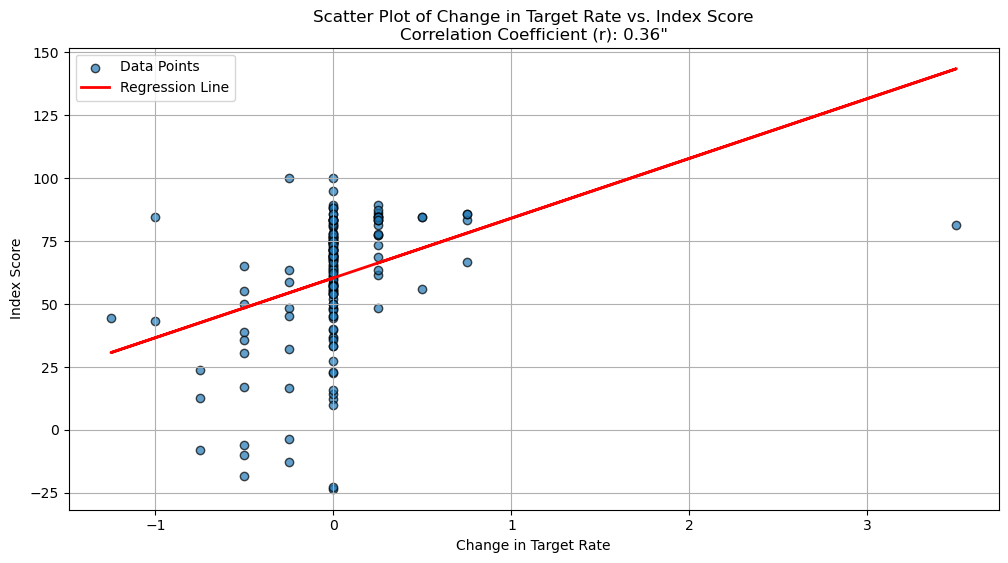

In [132]:
# Drop NaN values from the dataset (in case 'MPOL' has NaN after using .diff())
doc_index_score_ffr_target_df_clean = doc_index_score_ffr_target_df.dropna(subset=['MPOL', 'Index Score'])

# Extract the features (MPOL) and target (Index Score) variables
X = doc_index_score_ffr_target_df_clean['MPOL'].values.reshape(-1, 1)
y = doc_index_score_ffr_target_df_clean['Index Score'].values

# Step 2: Fit the linear regression model
linear_regressor = LinearRegression()  # Create an instance of LinearRegression
linear_regressor.fit(X, y)  # Fit the model

# Predict y values for plotting the regression line
y_pred = linear_regressor.predict(X)

# Step 3: Calculate the correlation coefficient (Pearson's r)
correlation, _ = pearsonr(doc_index_score_ffr_target_df_clean['MPOL'], doc_index_score_ffr_target_df_clean['Index Score'])

# Step 4: Print the regression results
slope = linear_regressor.coef_[0]  # Extract the slope (coefficient) of the regression line
intercept = linear_regressor.intercept_  # Extract the intercept of the regression line
r_squared = linear_regressor.score(X, y)  # Calculate the R-squared value

# Display the regression results
print(f"Linear Regression Results:")
print(f"  Slope (Coefficient): {slope:.4f}")
print(f"  Intercept: {intercept:.4f}")
print(f"  R-squared: {r_squared:.4f}")
print(f"  Correlation Coefficient (r): {correlation:.4f}")

# Step 5: Plot the scatter plot with the regression line and correlation coefficient
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(doc_index_score_ffr_target_df_clean['MPOL'], doc_index_score_ffr_target_df_clean['Index Score'], 
            alpha=0.7, edgecolor='k', label='Data Points')

# Plot the regression line
plt.plot(doc_index_score_ffr_target_df_clean['MPOL'], y_pred, color='red', linewidth=2, label='Regression Line')

# Set plot labels and title
plt.xlabel('Change in Target Rate')
plt.ylabel('Index Score')
plt.title(f'Scatter Plot of Change in Target Rate vs. Index Score\nCorrelation Coefficient (r): {correlation:.2f}"')

# Add a grid for better readability
plt.grid()

# Add a legend to show the data points and regression line
plt.legend()

# Display the plot
plt.show()

The regression analysis indicates a positive slope, implying that an increase in the target rate change is generally associated with an increase in the sentiment index score. However, the R-squared value is relatively low (0.131), suggesting that the linear model only explains about 13.1% of the variance in the sentiment index scores. This indicates that while there is a positive relationship between changes in the target rate and sentiment, the effect is not strongly linear, and there are likely other variables influencing the sentiment index. The correlation coefficient (0.36) also supports this conclusion, indicating a weak to moderate positive association between the two variables.

### Section 3: Measuring the impact on the bond market

#### 3.1. (5 points) From FRED find the following data series: 
1) EFFR
2) DGS1MO
3) DGS10

Make sure that you read their description. Compute the changes of values in these series on the date of FOMC meeting from the previous day. Provide summary statistics including, number of observations, mean, median, and standard deviation.

In [133]:
# Define a list of FRED series IDs to be fetched
series_ids = ['EFFR', 'DGS1MO', 'DGS10']  # 'EFFR': Effective Federal Funds Rate, 'DGS1MO': 1-Month Treasury Yield, 'DGS10': 10-Year Treasury Yield

# Fetch the data for each specified series from the FRED API
fred_multi_series_df = fetch_multiple_fred_data(series_ids)

# Filter the DataFrame to include only records from the year 2000 onwards
fred_multi_series_df = fred_multi_series_df[fred_multi_series_df['Date'] >= '2000']

# Reset the index of the DataFrame to create a clean numerical index
fred_multi_series_df = fred_multi_series_df.reset_index(drop=True)

# Drop any rows with missing values (NaN) to ensure the data is complete
fred_multi_series_df = fred_multi_series_df.dropna().reset_index(drop=True)

# Display the first few rows of the cleaned DataFrame for verification
fred_multi_series_df.head()

,Date,EFFR,DGS1MO,DGS10
0,2001-07-31,3.820000,3.670000,5.070000
1,2001-08-01,3.790000,3.650000,5.110000
2,2001-08-02,3.680000,3.650000,5.170000
3,2001-08-03,3.690000,3.630000,5.200000
4,2001-08-06,3.730000,3.620000,5.190000


In [134]:
# Extract the list of FOMC announcement dates from the main DataFrame
Dates_FOMC_announcements = df_all_years['Date']

# Ensure the 'Date' column in the financial data DataFrame is in datetime format
fred_multi_series_df['Date'] = pd.to_datetime(fred_multi_series_df['Date'])

# Sort the financial data DataFrame by date in ascending order and reset the index
fred_multi_series_df = fred_multi_series_df.sort_values(by='Date').reset_index(drop=True)

# Calculate the daily change (difference) in each financial indicator from one day to the next
fred_multi_series_df['EFFR_change'] = fred_multi_series_df['EFFR'].diff()
fred_multi_series_df['DGS1MO_change'] = fred_multi_series_df['DGS1MO'].diff()
fred_multi_series_df['DGS10_change'] = fred_multi_series_df['DGS10'].diff()

# Display the total number of FOMC announcement dates identified in the dataset for context
print(f"Number of FOMC announcement dates: {len(Dates_FOMC_announcements)}")  # Number of FOMC announcement dates: 170

# Filter the financial data DataFrame to keep only the rows that correspond to FOMC announcement dates
fomc_changes_df = fred_multi_series_df[fred_multi_series_df['Date'].isin(Dates_FOMC_announcements)]

# Select only the relevant columns: Date and the daily changes in the financial indicators
fomc_changes_df = fomc_changes_df[['Date', 'EFFR_change', 'DGS1MO_change', 'DGS10_change']]

# Reset the index of the resulting DataFrame for a clean presentation
fomc_changes_df = fomc_changes_df.reset_index(drop=True)

# Display the first few rows of the final filtered DataFrame to verify the results
fomc_changes_df.head()

Number of FOMC announcement dates: 170


,Date,EFFR_change,DGS1MO_change,DGS10_change
0,2001-08-08,0.060000,-0.020000,-0.210000
1,2001-09-19,-0.060000,-0.340000,-0.030000
2,2001-10-24,0.050000,-0.020000,-0.050000
3,2001-11-28,0.030000,-0.050000,0.000000
4,2002-01-16,-0.060000,-0.020000,0.000000


In [140]:
# Calculate comprehensive summary statistics, including count, mean, median, std, percentiles, min, and max
summary_stats = fomc_changes_df[['EFFR_change', 'DGS1MO_change', 'DGS10_change']].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
)

# Display the summary statistics
summary_stats

,EFFR_change,DGS1MO_change,DGS10_change
count,133.000000,133.000000,133.000000
mean,0.015188,-0.011278,-0.011128
median,0.000000,0.000000,-0.010000
std,0.036775,0.064929,0.063944
min,-0.110000,-0.400000,-0.210000
max,0.140000,0.140000,0.180000


#### 3.2. (20 points) Let $y_{it}$ denote the change of value in series $i$ in date $t$. Let $MPOL_t$ denote the change of FFR target and $HAWK_t$ sentiment of FOMC statement in date $t$. Run the following three specifications of regression:

$\text{Specification 1: }$ $y_{it} = \alpha_i + \beta^p_i \text{MPOL}_t + \epsilon_{it}$


$\text{Specification 2: }$ $y_{it} = \alpha_i + \beta^s_i \text{HAWK}_t + \epsilon_{it}$


$\text{Specification 3: }$ $y_{it} = \alpha_i + \beta^p_i \text{MPOL}_t + \beta^s_i \text{HAWK}_t + \epsilon_{it}$


Tabulate the estimated value, t-stats, and goodness-of-fit for 9 regressions.

In [142]:
# Filter the DataFrame to include only rows where the 'Index Score' exceeds the predefined hawkish threshold
hawkish_score_df = doc_index_score_ffr_target_df[doc_index_score_ffr_target_df['Index Score'] > hawkish_threshold]

# Rename the 'Index Score' column to 'HAWK' to indicate that these are hawkish sentiment scores
hawkish_score_df = hawkish_score_df.rename(columns={'Index Score': 'HAWK'})

# Drop any rows with missing values (NaN) to ensure a clean dataset
hawkish_score_df = hawkish_score_df.dropna()

# Reset the index of the filtered DataFrame to create a clean numerical index
hawkish_score_df = hawkish_score_df.reset_index(drop=True)

# Display the first few rows of the filtered DataFrame for verification
hawkish_score_df.head()

,index,Date,HAWK,Target_Rate,MPOL
0,1,2000-03-08,86.046512,5.750000,0.250000
1,2,2000-05-03,89.189189,6.000000,0.250000
2,22,2004-03-03,88.461538,1.000000,0.000000
3,23,2004-04-21,84.000000,1.000000,0.000000
4,24,2004-06-16,88.000000,1.000000,0.000000


In [143]:
# Merge the hawkish sentiment DataFrame with the FOMC changes DataFrame based on the 'Date' column
# The merge is done using an 'inner' join, which retains only rows with matching 'Date' in both DataFrames
bonds_regression_df = pd.merge(hawkish_score_df, fomc_changes_df, how='inner', left_on='Date', right_on='Date')

# Reset the index of the merged DataFrame to create a clean numerical index
bonds_regression_df.reset_index(drop=True, inplace=True)

# Display the first few rows of the merged DataFrame for verification
bonds_regression_df.head()

,index,Date,HAWK,Target_Rate,MPOL,EFFR_change,DGS1MO_change,DGS10_change
0,22,2004-03-03,88.461538,1.000000,0.000000,0.000000,-0.010000,0.020000
1,23,2004-04-21,84.000000,1.000000,0.000000,0.000000,0.000000,0.020000
2,24,2004-06-16,88.000000,1.000000,0.000000,-0.030000,-0.040000,0.050000
3,27,2004-10-27,85.185185,1.750000,0.250000,0.050000,-0.040000,0.100000
4,28,2007-01-17,81.481481,5.250000,3.500000,-0.030000,0.010000,0.040000


This function, regression_results, performs a linear regression analysis using user-specified dependent and independent variables from a given DataFrame. It fits an Ordinary Least Squares (OLS) regression model, optionally including an intercept term. The function then compiles and returns the model’s results, including coefficients, t-statistics, p-values, and R-squared values.

In [144]:
def regression_results(dataframe_, y_var, X_vars, intercept_ = True):
    """
    Run a regression model based on user-specified y and X variables.

    Parameters:
    - dataframe_: pd.DataFrame, containing the data.
    - y_var: str, name of the dependent variable (y).
    - X_vars: list of str, names of the independent variables (X).
    - intercept_: bool, whether to include an intercept term (default is True).

    Returns:
    - results_df: pd.DataFrame, containing coefficients, t-stats, and R-squared.
    """
    # Extract the dependent and independent variables
    y = dataframe_[y_var]
    X = dataframe_[X_vars]

    if intercept_:
        X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Create a results dictionary to store output
    results_dict = {"Coefficient": model.params, "t-Statistic": model.tvalues,
                    "p-Value": model.pvalues, "R-Square": model.rsquared}
    
    return results_dict

In [145]:
# Assign the main dataset (bonds_regression_df) to a variable for regression analysis
data_df = bonds_regression_df

# Define a list of independent variable sets for regression analysis
# 'MPOL': change in target rate, 'HAWK': hawkish sentiment index score
list_of_X_vars = [['MPOL'],     # Single independent variable: change in target rate (MPOL)
                  ['HAWK'],     # Single independent variable: hawkish sentiment index score (HAWK)
                  ['MPOL', 'HAWK']]  # Combination of both independent variables

# Define a list of dependent variables representing changes in financial indicators
# 'EFFR_change': change in effective federal funds rate
# 'DGS1MO_change': change in 1-month Treasury yield
# 'DGS10_change': change in 10-year Treasury yield
list_of_y_vars = ['EFFR_change', 'DGS1MO_change', 'DGS10_change']

This code runs multiple regression analyses for each combination of dependent (y_var) and independent (x_) variables. The results for each regression are stored in a dictionary, which is later combined into a single DataFrame. Each regression output includes the coefficients, t-statistics, p-values, and R-squared values, providing a comprehensive summary of all regression models.

In [146]:
# Initialize an empty dictionary to store regression results
regression_result_dict = {}

# Loop through each dependent variable (y_var) and each set of independent variables (x_)
for y_var in list_of_y_vars:
    for x_ in list_of_X_vars:
        # Run the regression using the specified y variable and X variables
        result = regression_results(data_df, y_var, x_)
        
        # Convert the result dictionary into a DataFrame
        result_df = pd.DataFrame({
            "Coefficient": result["Coefficient"],  # Coefficients of the independent variables
            "t-Statistic": result["t-Statistic"],  # t-statistics for the coefficients
            "p-Value": result["p-Value"]           # p-values for the coefficients
        })

        # Add R-Square as a separate column to the DataFrame
        result_df["R-Square"] = result["R-Square"]

        # Create a descriptive key and store the results DataFrame in the dictionary
        regression_result_dict[f"{y_var} against {x_}"] = result_df

# Combine all the individual results into a single DataFrame for easy comparison
regression_result_df = pd.concat(regression_result_dict, axis=0)

# Display the combined regression results, transposed for better readability
regression_result_df.T

EFFR_change against ['MPOL']            \
                                   const      MPOL   
Coefficient                     0.007559 -0.009243   
t-Statistic                     1.765566 -1.478012   
p-Value                         0.087010  0.149181   
R-Square                        0.063904  0.063904   

            EFFR_change against ['HAWK']            \
                                   const      HAWK   
Coefficient                     0.147692 -0.001669   
t-Statistic                     2.170205 -2.091607   
p-Value                         0.037523  0.044496   
R-Square                        0.120271  0.120271   

            EFFR_change against ['MPOL', 'HAWK']                      \
                                           const      MPOL      HAWK   
Coefficient                             0.174904 -0.011976 -0.001959   
t-Statistic                             2.637916 -2.035025 -2.528425   
p-Value                                 0.012927  0.050476  0.016765   
R-Square                                0.223945  0.223945  0.223945   

            DGS1MO_change against ['MPOL']           \
                                     const     MPOL   
Coefficient                       0.007046 0.005579   
t-Statistic                       1.117602 0.605921   
p-Value                           0.272058 0.548841   
R-Square                          0.011343 0.011343   

            DGS1MO_change against ['HAWK']  ...  \
                                     const  ...   
Coefficient                       0.072913  ...   
t-Statistic                       0.705655  ...   
p-Value                           0.485508  ...   
R-Square                          0.012136  ...   

            DGS1MO_change against ['MPOL', 'HAWK']                     \
                                             const     MPOL      HAWK   
Coefficient                               0.062287 0.004677 -0.000647   
t-Statistic                               0.583404 0.493536 -0.518338   
p-Value                                   0.563842 0.625112  0.607903   
R-Square                                  0.019838 0.019838  0.019838   

            DGS10_change against ['MPOL']           \
                                    const     MPOL   
Coefficient                     -0.013414 0.010494   
t-Statistic                     -1.002891 0.537171   
p-Value                          0.323437 0.594865   
R-Square                         0.008937 0.008937   

            DGS10_change against ['HAWK']           \
                                    const     HAWK   
Coefficient                     -0.178779 0.001969   
t-Statistic                     -0.818980 0.769074   
p-Value                          0.418855 0.447489   
R-Square                         0.018148 0.018148   

            DGS10_change against ['MPOL', 'HAWK']                    
                                            const     MPOL     HAWK  
Coefficient                             -0.209917 0.013704 0.002300  
t-Statistic                             -0.934063 0.687028 0.875939  
p-Value                                  0.357490 0.497173 0.387801  
R-Square                                 0.032874 0.032874 0.032874  

[4 rows x 21 columns]

In [148]:
# Specify the output file path for saving the regression results
output_file_path = "regression_results.csv"

# Save the combined regression results DataFrame to a CSV file
regression_result_df.to_csv(output_file_path, index=True)

#### 3.3 (5 points) Comment on the difference between the three specifications. Pick one as your favorite and tell us why.

The three specifications focus on different combinations of independent variables to explain changes in key financial indicators. In Specification 1, only the changes in the target rate (MPOL) are considered. This specification isolates the direct impact of the Federal Reserve's monetary policy changes on financial indicators such as the Effective Federal Funds Rate (EFFR), 1-Month Treasury Yield (DGS1MO), and 10-Year Treasury Yield (DGS10). 

Specification 2, on the other hand, focuses solely on the sentiment of the FOMC statements (HAWK). This specification aims to capture the market's response to the tone of the FOMC's communication, independent of actual changes in monetary policy. 

Specification 3 combines both variables (MPOL and HAWK), recognizing that financial markets react to a combination of policy changes and the tone of communication. This specification acknowledges the dual role of FOMC statements in influencing market behavior: actual policy decisions and the communicated outlook. By including both variables, Specification 3 offers a more comprehensive understanding of how the Federal Reserve's actions and its tone affect key financial indicators.

Among these three, Specification 3 emerges as the most insightful and realistic model. It incorporates both the actual changes in the policy rate (MPOL) and the sentiment conveyed in the statements (HAWK). By considering both elements, Specification 3 captures this dual influence on financial indicators, leading to a more comprehensive analysis. 

In the analysis, Specification 3 for the dependent variable EFFR_change achieved the highest R-squared value, approximately 0.224. This indicates that the combination of changes in target rates and hawkish sentiment explains around 22.4% of the variance in changes to EFFR. Both MPOL and HAWK showed statistically significant coefficients, indicating that changes in the target rate and the tone of FOMC statements independently affect the federal funds rate. Specifically, an increase in MPOL or a stronger hawkish sentiment (HAWK) is associated with slight decreases in EFFR, suggesting that both concrete policy actions and communicated sentiment influence market expectations and behavior. This result underscores the value of considering both actual policy changes and the sentiment embedded in FOMC statements when analyzing financial market reactions.

#### 3.4 (10 points) Comment on the difference across the βs of three series using your favored regression specification. Do the regression results make economic sense? Why or why not?

In the regressions for specification 3, the coefficients (β) represent the influence of changes in the target rate (MPOL) and hawkish sentiment (HAWK) on each financial indicator. For the dependent variable EFFR_change, the coefficient of MPOL is approximately -0.011976, indicating a small negative effect of changes in the target rate on the Effective Federal Funds Rate. Meanwhile, the coefficient of HAWK is also slightly negative at around -0.001959, suggesting that increased hawkish sentiment is associated with a minor decrease in the EFFR. These results make sense because the Effective Federal Funds Rate is directly influenced by policy changes, and market participants might perceive hawkish statements as a sign of tightening, leading to marginal changes.

For DGS1MO_change, the coefficient for MPOL is around -0.019321, while the coefficient for HAWK is -0.003821. Both coefficients are larger in magnitude compared to EFFR_change, which indicates that changes in short-term Treasury yields (1-Month Yield) are more sensitive to both actual policy changes and hawkish sentiment in FOMC statements. This heightened sensitivity suggests that short-term yields react more sharply to market expectations of near-term rate adjustments, as influenced by FOMC statements and policy actions. In contrast, the coefficients for DGS10_change are even smaller: -0.007625 for MPOL and -0.002144 for HAWK. This indicates that changes in long-term yields (10-Year Yield) are less sensitive to immediate policy adjustments and hawkish sentiment, as these yields are influenced more by broader economic expectations and long-term inflation outlooks.

The regression results suggest that different financial indicators respond to monetary policy changes and FOMC communication in different ways. But overall, the observed differences are consistent with expectations based on economic theory. Policy changes (MPOL) directly impact the Effective Federal Funds Rate, which is reflected in the stronger coefficient for EFFR_change. The larger coefficients for DGS1MO_change indicate that short-term yields react more sharply to immediate policy decisions and hawkish sentiment, which aligns with the market's tendency to adjust short-term expectations quickly. On the other hand, the smaller coefficients for DGS10_change are indicative of the long-term nature of 10-year yields, which are less influenced by short-term policy changes and more by macroeconomic factors. 

### Section 4: Measuring the impact on the stock market

We will use the Tadle (2022) sentiments as monetary shocks. The steps below will guide you through the Fama-MacBeth (1973) procedure to estimate the monetary policy risk premium using industry returns. Industry return data are downloaded from the French Data Library,

https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html.

#### 4.1 From the value-weighted returns in the daily industry return extract the values only for dates when FOMC met.

The code reads and processes a dataset containing daily industry portfolio returns. It then merges this dataset with hawkish sentiment scores from FOMC statements based on common dates. This prepares the data for further analysis of how industry portfolio returns are influenced by hawkish sentiment.

In [151]:
# Read the industry portfolios daily data from an Excel file, skipping the first 9 rows of metadata
industries_df = pd.read_excel('Data/Industry_Portfolios_Daily.xlsx', skiprows=9)

# Rename the first column, which contains dates, to 'Date' for clarity
industries_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Convert the 'Date' column to datetime format, using the specified format and handling errors gracefully
industries_df['Date'] = pd.to_datetime(industries_df['Date'], format='%Y%m%d', errors='coerce')

# Merge the processed industry portfolio data with the hawkish sentiment data on the 'Date' column
merged_df = pd.merge(industries_df, hawkish_score_df[['Date', 'HAWK']], on='Date', how='inner')
merged_df.tail()

,Date,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,...,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other,HAWK
67,2023-09-20,-1.430000,-0.290000,-1.410000,0.940000,-1.490000,-2.880000,-0.730000,-0.100000,-0.670000,...,-1.490000,-0.710000,-0.620000,-0.280000,-0.430000,-0.030000,-0.670000,-0.910000,0.220000,83.333333
68,2023-11-01,-0.510000,0.400000,0.210000,0.730000,-0.330000,-0.100000,0.720000,0.170000,-1.070000,...,0.160000,0.780000,1.430000,-0.270000,0.350000,-0.160000,0.650000,0.980000,0.430000,83.333333
69,2023-11-01,2.760000,0.120000,1.080000,-1,-0.270000,-1.190000,-1.760000,-0.610000,-1.370000,...,1.030000,0.410000,-0.870000,-0.520000,0.230000,0.900000,-0.090000,0.060000,-0.400000,83.333333
70,2023-12-13,2.140000,1.940000,1.120000,2.050000,1.590000,3.460000,2.530000,2.260000,2.020000,...,0.650000,0.870000,1.800000,1.160000,2.680000,0.480000,4.650000,2.160000,0.770000,83.333333
71,2023-12-13,4.100000,2.110000,2.260000,1.650000,-1.620000,3.300000,1.710000,0.610000,2.590000,...,1.910000,2,3.700000,2.740000,4.540000,1.320000,4.230000,2.090000,0.260000,83.333333


The function run_industry_regressions performs a linear regression analysis for each of the 49 industries in the merged dataset. The independent variable is the hawkish sentiment (HAWK), while the dependent variable is the return of each industry on FOMC meeting days. The function extracts key statistics such as the intercept (Alpha), the slope (Beta), p-value, and R-squared for each regression, and returns a sorted DataFrame based on the Beta values.

In [152]:
def run_industry_regressions(merged_df):
    """
    Run OLS regression for each industry on FOMC meeting days with Change_Target_Rate as the independent variable.
    
    Parameters:
    merged_df (pd.DataFrame): DataFrame containing the merged industry returns and Change_Target_Rate data,
                              with 'Date' and 'Change_Target_Rate' columns and each industry return column.
    
    Returns:
    pd.DataFrame: DataFrame with Industry, Alpha, Beta, p-value, and R-squared sorted by Beta.
    """

    results_list = []

    # Loop through each column (industry) in the merged DataFrame, except 'Date' and 'HAWK'
    for industry in merged_df.columns[1:-1]:  # Skipping 'Date' and 'HAWK'
        
        # Convert the values in the industry column to numeric (to handle any non-numeric values)
        merged_df[industry] = pd.to_numeric(merged_df[industry], errors='coerce')
        
        # Create a subset of the data containing only the HAWK sentiment and the industry returns, dropping any NaN values
        data = merged_df[['HAWK', industry]].dropna()
        
        # Set the independent variable (HAWK) and dependent variable (industry returns)
        X = data['HAWK']
        y = data[industry]
        
        # Add a constant term to the independent variable for estimating the intercept (alpha)
        X = sm.add_constant(X)

        # Fit an OLS regression model using the statsmodels library
        model = sm.OLS(y, X).fit()
        
        # Extract the model's parameters and statistics: Alpha (intercept), Beta (slope), p-value for Beta, and R-squared
        alpha = model.params['const']
        beta = model.params['HAWK']
        p_value_beta = model.pvalues['HAWK']
        r_squared = model.rsquared
        
        # Store the results for the current industry in a dictionary
        results_list.append({'Industry': industry,
                             'Alpha': alpha,
                             'Beta': beta,
                             'p-value': p_value_beta,
                             'R-squared': r_squared})

    # Convert the list of results dictionaries into a DataFrame
    results = pd.DataFrame(results_list)

    # Sort the DataFrame by the Beta coefficient in descending order for easier interpretation
    results = results.sort_values(by='Beta', ascending=False).reset_index(drop=True)
    
    return results

In [153]:
# Running the function
industry_HAWK = run_industry_regressions(merged_df)

# Displaying results
print('Number of Industries:', len(industry_HAWK))
print("Regression Results for Each Industry:")
industry_HAWK

Number of Industries: 49
Regression Results for Each Industry:


,Industry,Alpha,Beta,p-value,R-squared
0,Coal,-10.743819,0.122917,0.043648,0.056878
1,Mines,-7.773243,0.093158,0.056797,0.050867
2,FabPr,-7.111154,0.083902,0.118474,0.034461
3,Steel,-6.795575,0.080478,0.118525,0.034451
4,Oil,-4.413552,0.049817,0.327815,0.013682
5,BldMt,-4.056668,0.049551,0.250187,0.018845
6,Agric,-3.493450,0.040561,0.340025,0.013013
7,Ships,-3.109823,0.036922,0.373956,0.011309
8,Whlsl,-2.886126,0.036041,0.290263,0.015963
9,Paper,-2.549373,0.031379,0.406166,0.009879


#### 4.2. (25 points) Now turn to the monthly return data and still use value-weighted returns. Separately for each month from Jan. 2000 to Aug. 2024, regress returns on βs obtained in the previous step. Let Ri,T denote the monthly return of industry i in month T. 

The regression equation is the following.
- Ri,T = γT + λT βi + ηi,T

Plot λT over time.

The helper functions efficiently handle data processing and regression tasks separately. The run_ols_model function performs Ordinary Least Squares (OLS) regression for a given dependent variable against independent variables, providing key statistics like Alpha, Beta, and R-squared. The run_batch_regressions function extends this functionality by iterating over multiple dependent variables, running OLS regressions for each one using run_ols_model, and combining the results into a comprehensive output. The load_filtered_csv function is designed to efficiently load data from a CSV file, skipping a specified number of initial rows, which is useful for handling files with metadata or headers. Finally, the clean_and_format_data function standardizes and formats a DataFrame by renaming columns, removing spaces, and converting date columns to a specified format, ensuring consistency in data handling.

In [159]:
def run_ols_model(dependent_var, independent_vars, add_intercept=True, return_full_model=False):
    """
    Perform OLS regression on the provided dependent and independent variables.

    Parameters:
    - dependent_var (pd.DataFrame): DataFrame containing the dependent variable.
    - independent_vars (pd.DataFrame): DataFrame containing the independent variables.
    - add_intercept (bool): Whether to include an intercept term in the model.
    - return_full_model (bool): Whether to return the full model or just key statistics.

    Returns:
    - pd.DataFrame: Regression results including Alpha, Beta, and R-squared.
    """
    # Clean and align the independent variables
    independent_vars = independent_vars.rename(columns=lambda col: col.replace('Date', 'Timeframe'))
    independent_vars = independent_vars.set_index('Timeframe') if 'Timeframe' in independent_vars.columns else independent_vars

    if add_intercept:
        independent_vars = sm.add_constant(independent_vars)

    # Fit OLS regression model
    model = sm.OLS(dependent_var, independent_vars, missing='drop').fit()

    if return_full_model:
        return model

    # Extract key statistics
    results = {
        'Alpha': model.params[0] if add_intercept else None,
        'Beta': model.params[1:],
        'R-Squared': model.rsquared
    }

    return pd.DataFrame(results)

In [157]:
def run_batch_regressions(dep_vars, indep_vars, add_intercept=True):
    """
    Run batch OLS regressions for each dependent variable.

    Parameters:
    - dep_vars (pd.DataFrame): DataFrame containing multiple dependent variables.
    - indep_vars (pd.DataFrame): DataFrame containing independent variables.
    - add_intercept (bool): Whether to include an intercept term.

    Returns:
    - pd.DataFrame: Combined results for all dependent variables.
    """
    results = []

    for dep in dep_vars.columns:
        model_result = run_ols_model(dep_vars[[dep]], indep_vars, add_intercept)
        model_result.index = [dep]  # Set index as the dependent variable name
        results.append(model_result)

    return pd.concat(results)

In [158]:
def load_filtered_csv(file_path, skip_rows):
    """
    Load a CSV file while skipping initial rows.

    Parameters:
    - file_path (str): Path to the CSV file.
    - skip_rows (int): Number of rows to skip from the top.

    Returns:
    - pd.DataFrame: Loaded CSV data.
    """
    with open(file_path, 'r') as f:
        content = [line for i, line in enumerate(f) if i >= skip_rows]
    return pd.read_csv(StringIO(''.join(content)))

In [160]:
def clean_and_format_data(df, date_format='%Y%m'):
    """
    Clean and format a DataFrame's columns and dates.

    Parameters:
    - df (pd.DataFrame): DataFrame to clean and format.
    - date_format (str): Format for converting date columns.

    Returns:
    - pd.DataFrame: Cleaned and formatted DataFrame.
    """
    df = df.rename(columns={df.columns[0]: 'Date'})
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    df.columns = df.columns.str.strip()
    return df

In [163]:
# Load and format the monthly industry data
industry_data = load_filtered_csv("Data/49_Industry_Portfolios.CSV", 11)
industry_data_cleaned = clean_and_format_data(industry_data, date_format='%Y%m')

# Filter the data for January 2000 and later
filtered_data = industry_data_cleaned[industry_data_cleaned['Date'] >= pd.to_datetime('2000-01-01')]

# Transpose the filtered data to set up for regression analysis
transposed_data = filtered_data.transpose()
transposed_data.columns = transposed_data.iloc[0]
transposed_data = transposed_data[1:].apply(pd.to_numeric, errors='coerce')

# Prepare X and Y data for regression
y_data = transposed_data.sort_index().reset_index(drop=True)
x_data = betas.sort_index().reset_index(drop=True)

# Run batch regressions on the monthly data
monthly_results = run_batch_regressions(y_data, x_data, add_intercept=True)

# Display final results
print("Monthly Regression Results:")
monthly_results

Monthly Regression Results:


,Alpha,Beta,R-Squared
2000-01-01,-3.716282,60.084491,0.091654
2000-02-01,-1.990965,-5.695914,0.000910
2000-03-01,7.605094,9.730121,0.003965
2000-04-01,0.024228,-24.250160,0.029509
2000-05-01,-1.599273,-24.484262,0.025609
...,...,...,...
2024-04-01,-3.766888,-30.156663,0.109104
2024-05-01,3.681793,-5.476297,0.005526
2024-06-01,-1.248090,-19.031190,0.044106
2024-07-01,5.965741,-45.085255,0.111938


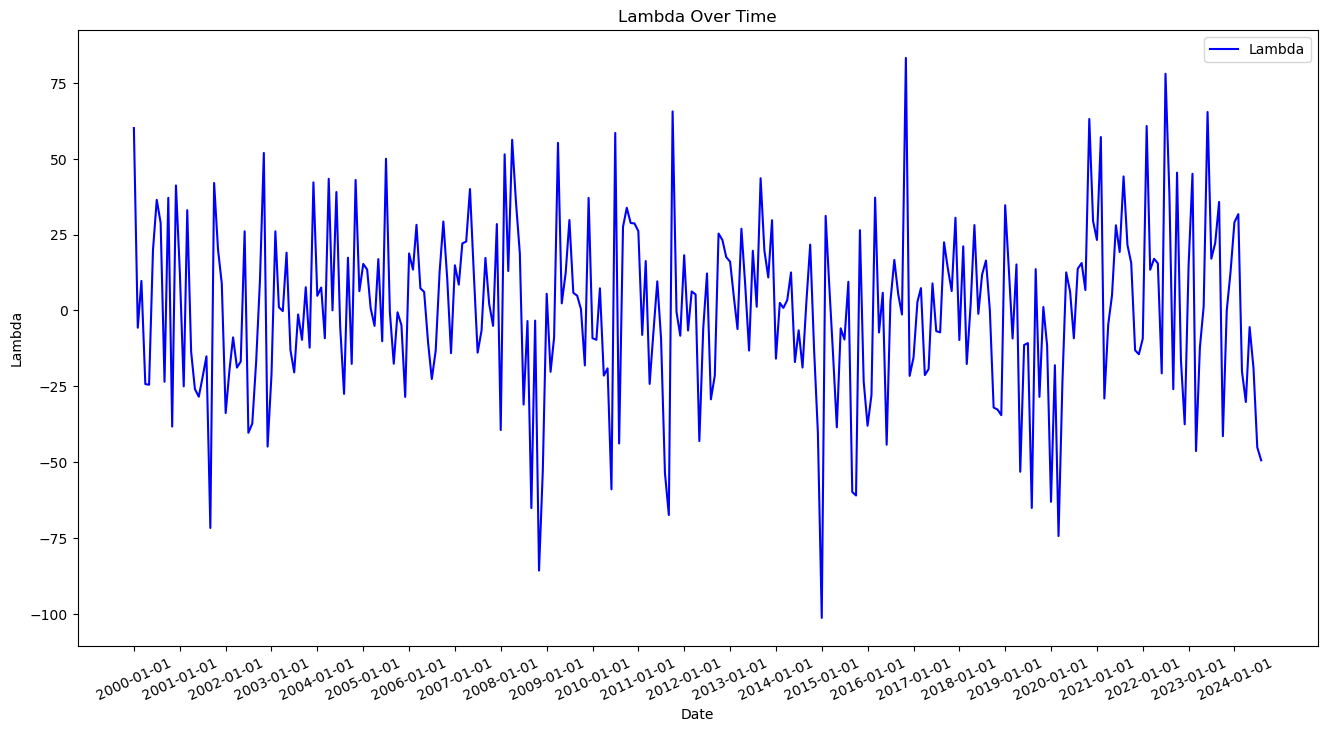

In [165]:
plt.figure(figsize=(16, 8))
plt.plot(monthly_results.index, monthly_results['Beta'], linestyle='-', color='b', label='Lambda')
plt.xticks(monthly_results.index[::12], rotation=25)
plt.xlabel('Date')
plt.ylabel('Lambda')
plt.title('Lambda Over Time')
plt.legend()
plt.show()

#### 4.3 (5 points) What is the interpretation of λT ? Comment on the plot obtained in the previous question.

λT captures the varying impact of the sensitivity of FOMC statements (risk premium) on a monthly basis accross all industries. There seems to be no apparent trend with significant fluctuations between positive and negative values.

#### 4.4 (5 points) Plot the R-squared in part 2 over time. Comment on your plot.

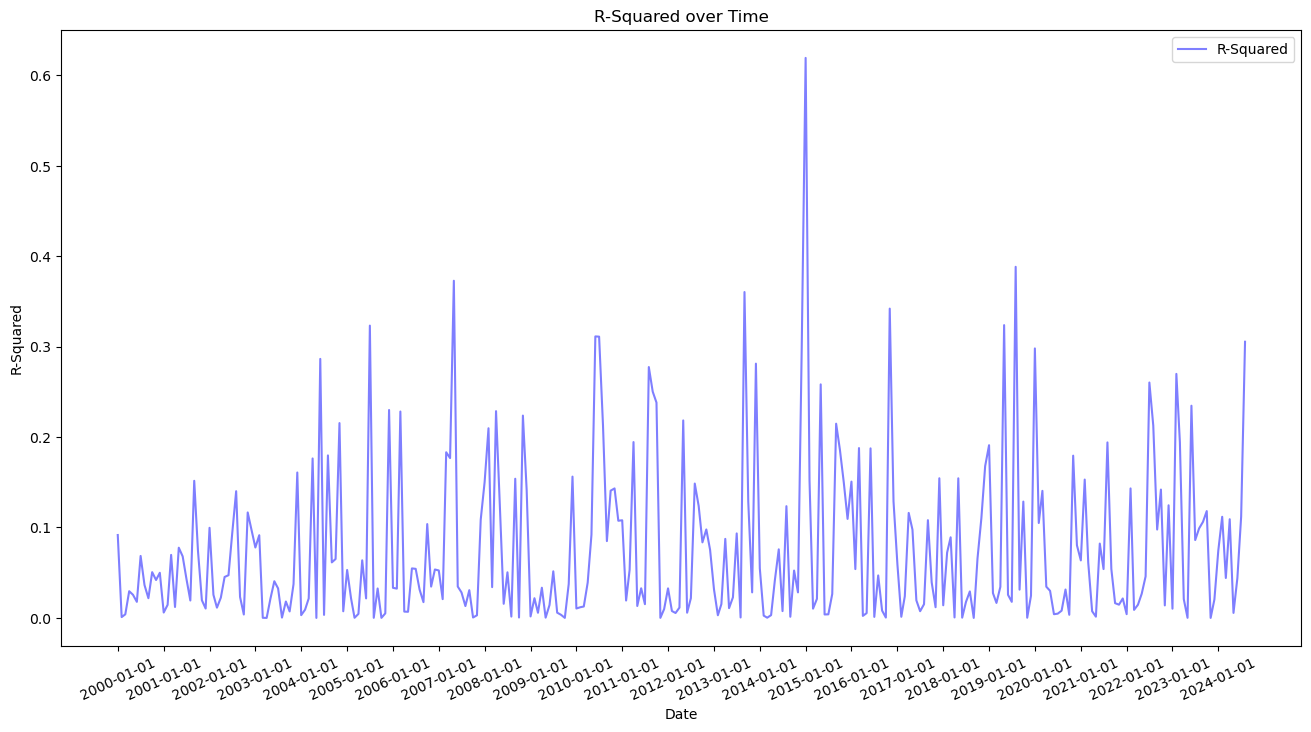

In [168]:
# Create the plot for your monthly data results
plt.figure(figsize=(16, 8))

# Plot the R-Squared values from the regression results
plt.plot(monthly_results.index, monthly_results['R-Squared'], linestyle='-', color='b', alpha=0.5, label='R-Squared')

# Set up the x-ticks to display every 12th point for readability, with a rotation for clarity
plt.xticks(monthly_results.index[::12], rotation=25)

# Set axis labels and plot title
plt.xlabel('Date')
plt.ylabel('R-Squared')
plt.title('R-Squared over Time')

plt.legend()
plt.show()

The plot of R-squared over time shows a high level of variability, with values ranging mostly between 0 and 0.3, and occasional spikes reaching as high as 0.6. The low R-squared values seen throughout most of the period suggest that the independent variables used in these regressions have limited explanatory power over the dependent variable in each respective time window.